# Assignment 3 

## Q-Learning on Cartpole

### Rajas Vaidya (MDS202131)
### Rishika Tibrewal (MDS202135)
### Shreyansh Rastogi (MDS202144)

In [1]:
%matplotlib inline

In [2]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt 

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
#set up the environment
env = gym.make("CartPole-v1", render_mode="rgb_array")
print(env.action_space.n)

2


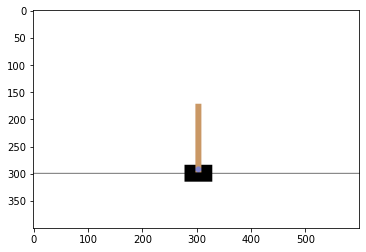

In [4]:
env.reset()
frame = env.render()
plt.imshow(frame)
plt.grid(False)

### To save an episode as gif and display it later

In [5]:
import imageio
import os
from IPython.display import HTML

def save_frames_as_gif(frames, path='./', filename='gym_animation.gif'):
    imageio.mimwrite(os.path.join(path, filename), frames, fps=50)

### Getting a sample episode

In [6]:
frames = []
env.reset()
total_reward = 0
for i in range(100):
    action = env.action_space.sample()
    next_state, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    total_reward += reward
    frame = env.render()
    frames.append(frame)
    if done:
        break

In [7]:
print("Game terminated after", len(frames), " steps with reward ", total_reward)
save_frames_as_gif(frames, path='./', filename='random_agent.gif')
HTML('<img src="./random_agent.gif">')

Game terminated after 32  steps with reward  32.0


### Defining the hyperparameters

In [8]:
LEARNING_RATE = 0.1

DISCOUNT = 0.9
EPISODES = 60000
total = 0
total_reward = 0
prior_reward = 0

Observation = [30, 30, 50, 50]
np_array_win_size = np.array([0.25, 0.25, 0.01, 0.1])

epsilon = 1

epsilon_decay_value = 0.97

In [9]:
q_table = np.random.uniform(low=0, high=1, size=(Observation + [env.action_space.n]))
q_table.shape

(30, 30, 50, 50, 2)

### To get the next state

In [10]:
def get_discrete_state(state):
    discrete_state = state/np_array_win_size+ np.array([15,10,1,10])
    return tuple(discrete_state.astype(np.int))

### Applying Q Learning

In [11]:
metrics = {'ep': [], 'avg': [], 'min': [], 'max': []}  # metrics recorded for graph
scores = []
for episode in range(EPISODES + 1): #go through the episodes
#     t0 = time.time() #set the initial time
    policy=[]
    discrete_state = get_discrete_state(env.reset()[0]) #get the discrete start for the restarted environment 
    done = False
    episode_reward = 0 #reward starts as 0 for each episode

    if episode % 1000 == 0: 
        print("Completed Episode: " + str(episode))

    while not done: 

        if np.random.random() > epsilon:

            action = np.argmax(q_table[discrete_state]) #take cordinated action
        else:

            action = np.random.randint(0, env.action_space.n) #do a random ation

        new_state, reward, truncated, terminated, _ = env.step(action) #step action to get new states, reward, and the "done" status.
        done=truncated or terminated
        episode_reward += reward #add the reward

        new_discrete_state = get_discrete_state(new_state)

        if episode % 2000 == 0: #render
            env.render()

        if not done: #update q-table
            max_future_q = np.max(q_table[new_discrete_state])

            current_q = q_table[discrete_state + (action,)]

            new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)

            q_table[discrete_state + (action,)] = new_q
        policy.append(action)
        discrete_state = new_discrete_state

    if epsilon > 0.05: #epsilon modification
        if episode_reward > prior_reward and episode > 10000:
            epsilon = math.pow(epsilon_decay_value, episode - 10000)

            if episode % 500 == 0:
                print("Epsilon: " + str(epsilon))

    total_reward += episode_reward #episode total reward
    prior_reward = episode_reward
    scores.append(episode_reward)

    if episode % 5000 == 0: #every 5000 episodes print the average time and the average reward

        mean_reward = total_reward / 5000
#         print("Mean Reward: " + str(mean_reward))
        total_reward = 0
        latestRuns = scores[-1000:]
        mean_reward = sum(latestRuns) / len(latestRuns)
        metrics['ep'].append(episode)
        metrics['avg'].append(mean_reward)
        metrics['min'].append(min(latestRuns))
        metrics['max'].append(max(latestRuns))
        print("Average:", mean_reward, "Min:", min(latestRuns), "Max:", max(latestRuns))

        
env.close()
print("Complete")

Completed Episode: 0
Average: 36.0 Min: 36.0 Max: 36.0
Completed Episode: 1000
Completed Episode: 2000
Completed Episode: 3000
Completed Episode: 4000
Completed Episode: 5000
Average: 21.269 Min: 8.0 Max: 104.0
Completed Episode: 6000
Completed Episode: 7000
Completed Episode: 8000
Completed Episode: 9000
Completed Episode: 10000
Average: 22.716 Min: 8.0 Max: 118.0
Completed Episode: 11000
Completed Episode: 12000
Completed Episode: 13000
Completed Episode: 14000
Completed Episode: 15000
Average: 195.304 Min: 19.0 Max: 500.0
Completed Episode: 16000
Completed Episode: 17000
Completed Episode: 18000
Completed Episode: 19000
Completed Episode: 20000
Average: 199.613 Min: 17.0 Max: 500.0
Completed Episode: 21000
Completed Episode: 22000
Completed Episode: 23000
Completed Episode: 24000
Completed Episode: 25000
Average: 182.854 Min: 14.0 Max: 500.0
Completed Episode: 26000
Completed Episode: 27000
Completed Episode: 28000
Completed Episode: 29000
Completed Episode: 30000
Average: 170.885 M

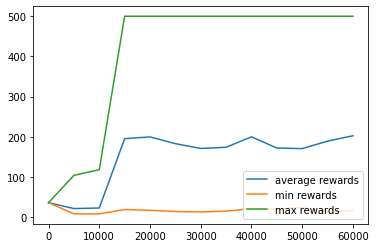

In [12]:
plt.plot(metrics['ep'], metrics['avg'], label="average rewards")
plt.plot(metrics['ep'], metrics['min'], label="min rewards")
plt.plot(metrics['ep'], metrics['max'], label="max rewards")
plt.legend(loc=4)

### Playing a sample game after learning

In [13]:
frames = []
env.reset()
done = False
episode_reward = 0
discrete_state = get_discrete_state(env.reset()[0])
for i in range(500):
    
    action = np.argmax(q_table[discrete_state]) #take cordinated action
    new_state, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    episode_reward += reward

    # Observe new state
    if not done:
        discrete_state = get_discrete_state(new_state)
    else:
        break

    frame = env.render()
    frames.append(frame)

    if done:
        break

In [14]:
print("Game terminated after", len(frames), "steps with reward", episode_reward)
save_frames_as_gif(frames, path='./', filename='RL_agent.gif')
HTML('<img src="./RL_agent.gif">')

Game terminated after 259 steps with reward 260.0


## Second policy where reward is +2 when angle is in (-12,-6) or (6,12) else 0

In [15]:
env_2 = gym.make("CartPole-v1", render_mode="rgb_array")

In [16]:
LEARNING_RATE = 0.1

DISCOUNT = 0.9
EPISODES = 70000
total = 0
total_reward = 0
prior_reward = 0

Observation = [30, 30, 50, 50]
np_array_win_size = np.array([0.25, 0.25, 0.01, 0.1])

epsilon = 1

epsilon_decay_value = 0.99995

In [17]:
q_table_2 = np.random.uniform(low=0, high=1, size=(Observation + [env_2.action_space.n]))
q_table_2.shape

(30, 30, 50, 50, 2)

### Applying Q Learning on the modified Cartpole
Converted degree to radian as the angle value is in radians

In [18]:
metrics = {'ep': [], 'avg': [], 'min': [], 'max': []}  # metrics recorded for graph
scores = []
for episode in range(EPISODES + 1): #go through the episodes
    policy=[]
    discrete_state = get_discrete_state(env_2.reset()[0]) #get the discrete start for the restarted environment 
    done = False
    episode_reward = 0 #reward starts as 0 for each episode

    if episode % 1000 == 0: 
        print("Completed Episode: " + str(episode))

    while not done: 
        
        if np.random.random() > epsilon:
            action = np.argmax(q_table_2[discrete_state]) #take cordinated action
        else:
            action = np.random.randint(0, env_2.action_space.n) #do a random ation
        
        new_state, reward, truncated, terminated, _ = env_2.step(action) #step action to get new states, reward, and the "done" status.
        done=truncated or terminated
        
        if -(12*np.pi)/180 < new_state[2] < -(6*np.pi)/180 or (12*np.pi)/180 > new_state[2] > (6*np.pi)/180:
            reward = 2
        else:
            reward = 0
        
        episode_reward += reward #add the reward
        
        new_discrete_state = get_discrete_state(new_state)

        if episode % 1000 == 0: #render
            env_2.render()

        if not done: #update q-table
            max_future_q = np.max(q_table_2[new_discrete_state])

            current_q = q_table_2[discrete_state + (action,)]

            new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)

            q_table_2[discrete_state + (action,)] = new_q
        policy.append(action)
        discrete_state = new_discrete_state
#         discrete_state = new_state
        
    if epsilon > 0.05: #epsilon modification
        if episode_reward > prior_reward and episode > 10000:
            epsilon = math.pow(epsilon_decay_value, episode - 10000)
            if episode % 500 == 0:
                print("Epsilon: " + str(epsilon))

    total_reward += episode_reward #episode total reward
    prior_reward = episode_reward
    scores.append(episode_reward)

    if episode % 1000 == 0: #every 1000 episodes print the average time and the average reward

        mean_reward = total_reward / 1000
#         print("Mean Reward: " + str(mean_reward))
        total_reward = 0
        
        latestRuns = scores[-1000:]
        mean_reward = sum(latestRuns) / len(latestRuns)
        metrics['ep'].append(episode)
        metrics['avg'].append(mean_reward)
        metrics['min'].append(min(latestRuns))
        metrics['max'].append(max(latestRuns))
        print("Average:", mean_reward, "Min:", min(latestRuns), "Max:", max(latestRuns))
      
env_2.close()
print("Complete")

Completed Episode: 0
Average: 8.0 Min: 8 Max: 8
Completed Episode: 1000
Average: 12.064 Min: 4 Max: 86
Completed Episode: 2000
Average: 12.294 Min: 4 Max: 82
Completed Episode: 3000
Average: 12.626 Min: 4 Max: 104
Completed Episode: 4000
Average: 12.234 Min: 4 Max: 86
Completed Episode: 5000
Average: 11.39 Min: 4 Max: 56
Completed Episode: 6000
Average: 11.782 Min: 4 Max: 78
Completed Episode: 7000
Average: 12.43 Min: 4 Max: 76
Completed Episode: 8000
Average: 12.036 Min: 4 Max: 84
Completed Episode: 9000
Average: 12.254 Min: 4 Max: 100
Completed Episode: 10000
Average: 12.18 Min: 4 Max: 96
Completed Episode: 11000
Average: 12.368 Min: 4 Max: 86
Epsilon: 0.9277417467531685
Completed Episode: 12000
Epsilon: 0.9048351558698463
Average: 12.692 Min: 4 Max: 90
Epsilon: 0.8824941446941661
Completed Episode: 13000
Epsilon: 0.8607047486686201
Average: 12.706 Min: 4 Max: 84
Epsilon: 0.8394533480303666
Completed Episode: 14000
Epsilon: 0.818726659298009
Average: 13.85 Min: 4 Max: 90
Completed Ep

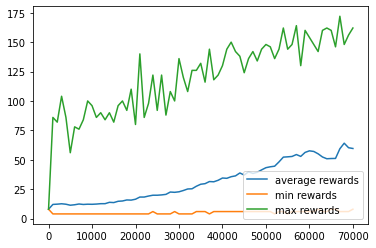

In [19]:
plt.plot(metrics['ep'], metrics['avg'], label="average rewards")
plt.plot(metrics['ep'], metrics['min'], label="min rewards")
plt.plot(metrics['ep'], metrics['max'], label="max rewards")
plt.legend(loc=4)

### Playing modified cartpole after learning

In [22]:
frames = []
env_2.reset()
done = False
episode_reward = 0
discrete_state = get_discrete_state(env_2.reset()[0])
for i in range(500):
    
    action = np.argmax(q_table_2[discrete_state]) #take cordinated action
    new_state, reward, terminated, truncated, info = env_2.step(action)
    done = terminated or truncated
    
    if -(12*np.pi)/180 < new_state[2] < -(6*np.pi)/180 or (12*np.pi)/180 > new_state[2] > (6*np.pi)/180:
        reward = 2
    else:
        reward = 0
    
    episode_reward += reward

    # Observe new state
    if not done:
        discrete_state = get_discrete_state(new_state)
    else:
        break

    frame = env_2.render()
    frames.append(frame)

    if done:
        break

In [23]:
print("Game terminated after", len(frames), "steps with reward", episode_reward)
save_frames_as_gif(frames, path='./', filename='RL_agent_2.gif')
HTML('<img src="./RL_agent_2.gif">')

Game terminated after 48 steps with reward 82
